In [65]:

#IMPORT THE LIBRARIES
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
import IPython.display as ipd
from IPython.display import Audio
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM,BatchNormalization , GRU
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD



import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 
import tensorflow as tf 
print ("Done")

Done


In [66]:
!apt-get update
!apt-get install -y libsndfile1

'apt-get' is not recognized as an internal or external command,
operable program or batch file.
'apt-get' is not recognized as an internal or external command,
operable program or batch file.


# Importing Data 

                                              Ravdess Dataframe
Here is the filename identifiers as per the official RAVDESS website:

* Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
* Vocal channel (01 = speech, 02 = song).
* Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
* Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
* Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
* Repetition (01 = 1st repetition, 02 = 2nd repetition).
* Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

So, here's an example of an audio filename. 02-01-06-01-02-01-12.mp4 This means the meta data for the audio file is:

* Video-only (02)
* Speech (01)
* Fearful (06)
* Normal intensity (01)
* Statement "dogs" (02)
* 1st Repetition (01)
* 12th Actor (12) - Female (as the actor ID number is even)

In [67]:
ravdess = "RAVDESS Emotional speech audio/audio_speech_actors_01-24"
ravdess_directory_list = os.listdir(ravdess)
Crema = "AudioWAV//"
Tess = "TESS Toronto emotional speech set data/TESS Toronto emotional speech set data"
tess_directory_list = os.listdir(Tess)
Savee = "ALL//"

# preprocessing

**Ravdees**

In [68]:
file_emotion = []
file_path = []
for actor_dir in ravdess_directory_list:
    actor_path = os.path.join(ravdess, actor_dir)
    
    # Check if the item in the directory is a directory itself
    if os.path.isdir(actor_path):
        actor_files = os.listdir(actor_path)
        
        for file_name in actor_files:
            part = file_name.split('.')[0].split('-')
            # third part in each file represents the emotion associated with that file.
            file_emotion.append(int(part[2]))
            file_path.append(os.path.join(actor_path, file_name))

# Print information about the first file
print("Actor:", ravdess_directory_list[0])
print("File Name:", actor_files[0])
print("File Path:", file_path[0])
print("Emotion:", file_emotion[0])
print("File Name (inside loop):", file_name)

Actor: Actor_01
File Name: 03-01-01-01-01-01-24.wav
File Path: RAVDESS Emotional speech audio/audio_speech_actors_01-24\Actor_01\03-01-01-01-01-01-01.wav
Emotion: 1
File Name (inside loop): 03-01-08-02-02-02-24.wav


In [69]:
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
ravdess_df = pd.concat([emotion_df, path_df], axis=1)
# changing integers to actual emotions.
ravdess_df.Emotions.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust',
                             8:'surprise'},
                            inplace=True)
print(ravdess_df.Emotions.value_counts())



Emotions
neutral     288
happy       192
sad         192
angry       192
fear        192
disgust     192
surprise    192
Name: count, dtype: int64


**Crema DataFrame**

CREMA-D is a data set of 7,442 original clips from 91 actors. These clips were from 48 male and 43 female actors between the ages of 20 and 74 coming from a variety of races and ethnicities (African America, Asian, Caucasian, Hispanic, and Unspecified). Actors spoke from a selection of 12 sentences. The sentences were presented using one of six different emotions (Anger, Disgust, Fear, Happy, Neutral, and Sad) and four different emotion levels (Low, Medium, High, and Unspecified).

In [70]:
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(Crema + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()
print(Crema_df.Emotions.value_counts())


Emotions
angry      1271
disgust    1271
fear       1271
happy      1271
sad        1271
neutral    1087
Name: count, dtype: int64


**TESS dataset**

There are a set of 200 target words were spoken in the carrier phrase "Say the word _' by two actresses (aged 26 and 64 years) and recordings were made of the set portraying each of seven emotions (anger, disgust, fear, happiness, pleasant surprise, sadness, and neutral). There are 2800 data points (audio files) in total.

The dataset is organised such that each of the two female actor and their emotions are contain within its own folder. And within that, all 200 target words audio file can be found. The format of the audio file is a WAV format

In [71]:
file_emotion = []
file_path = []

for dir_name in tess_directory_list:
    dir_path = os.path.join(Tess, dir_name)
    
    if os.path.isdir(dir_path):
        files_in_dir = os.listdir(dir_path)
        
        for file_name in files_in_dir:
            part = file_name.split('.')[0]
            part = part.split('_')[2]
            
            if part == 'ps':
                file_emotion.append('surprise')
            else:
                file_emotion.append(part)
                
            file_path.append(os.path.join(dir_path, file_name))

# DataFrame for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# DataFrame for path of files
path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
Tess_df.head()

print(Tess_df.Emotions.value_counts())


Emotions
angry       400
disgust     400
fear        400
happy       400
neutral     400
surprise    400
sad         400
Name: count, dtype: int64


**SAVEE Dataset**

Context
The SAVEE database was recorded from four native English male speakers (identified as DC, JE, JK, KL), postgraduate students and researchers at the University of Surrey aged from 27 to 31 years. Emotion has been described psychologically in discrete categories: anger, disgust, fear, happiness, sadness and surprise. This is supported by the cross-cultural studies of Ekman [6] and studies of automatic emotion recognition tended to focus on recognizing these [12]. We added neutral to provide recordings of 7 emotion categories. The text material consisted of 15 TIMIT sentences per emotion: 3 common, 2 emotion-specific and 10 generic sentences that were different for each emotion and phonetically-balanced. The 3 common and 2 × 6 = 12 emotion-specific sentences were recorded as neutral to give 30 neutral sentences.

Content
This results in a total of 120 utterances per speaker, for example:

Common: She had your dark suit in greasy wash water all year.
Anger: Who authorized the unlimited expense account?
Disgust: Please take this dirty table cloth to the cleaners for me.
Fear: Call an ambulance for medical assistance.
Happiness: Those musicians harmonize marvelously.
Sadness: The prospect of cutting back spending is an unpleasant one for any governor.
Surprise: The carpet cleaners shampooed our oriental rug.
Neutral: The best way to learn is to solve extra problems.

In [72]:
savee_directory_list = os.listdir(Savee)

file_emotion = []
file_path = []

for file in savee_directory_list:
    file_path.append(Savee + file)
    part = file.split('_')[1]
    ele = part[:-6]
    if ele=='a':
        file_emotion.append('angry')
    elif ele=='d':
        file_emotion.append('disgust')
    elif ele=='f':
        file_emotion.append('fear')
    elif ele=='h':
        file_emotion.append('happy')
    elif ele=='n':
        file_emotion.append('neutral')
    elif ele=='sa':
        file_emotion.append('sad')
    else:
        file_emotion.append('surprise')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Savee_df = pd.concat([emotion_df, path_df], axis=1)
Savee_df.head()
print(Savee_df.Emotions.value_counts())


Emotions
neutral     120
surprise     61
angry        60
disgust      60
fear         60
happy        60
sad          60
Name: count, dtype: int64


**Integration**

In [73]:
# creating Dataframe using all the 4 dataframes we created so far.
data_path = pd.concat([ravdess_df, Crema_df, Tess_df, Savee_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.head()

,Emotions,Path
0,neutral,RAVDESS Emotional speech audio/audio_speech_ac...
1,neutral,RAVDESS Emotional speech audio/audio_speech_ac...
2,neutral,RAVDESS Emotional speech audio/audio_speech_ac...
3,neutral,RAVDESS Emotional speech audio/audio_speech_ac...
4,neutral,RAVDESS Emotional speech audio/audio_speech_ac...


In [74]:
print(data_path.Emotions.value_counts())


Emotions
happy       1923
sad         1923
angry       1923
fear        1923
disgust     1923
neutral     1895
surprise     653
Name: count, dtype: int64


>*                           Data Visualisation and Exploration

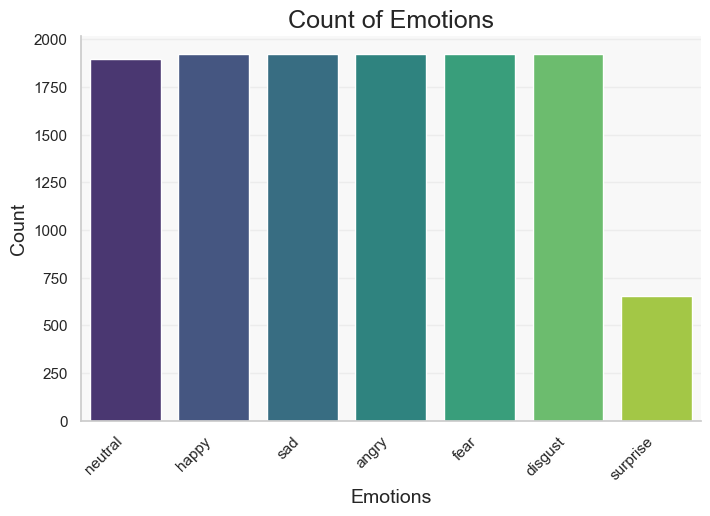

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the overall style for the plot
sns.set(style="whitegrid", rc={"axes.facecolor": "#F8F8F8", "grid.color": "#ECECEC"})

# Plotting
plt.figure(figsize=(8, 5))
sns.countplot(x='Emotions', data=data_path, palette="viridis")

# Title and labels
plt.title('Count of Emotions', size=18)
plt.ylabel('Count', size=14)
plt.xlabel('Emotions', size=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Despine to remove top and right spines
sns.despine(top=True, right=True, left=False, bottom=False)

# Show the plot
plt.show()


In [76]:
import librosa

file_path = "ALL/DC_a01.wav"

# Try to load the audio file
try:
    data, sr = librosa.load(file_path)
    print("Sampling Rate (sr):", sr)
except Exception as e:
    print("Error:", e)


Sampling Rate (sr): 22050


In [77]:
ipd.Audio(data,rate=sr)

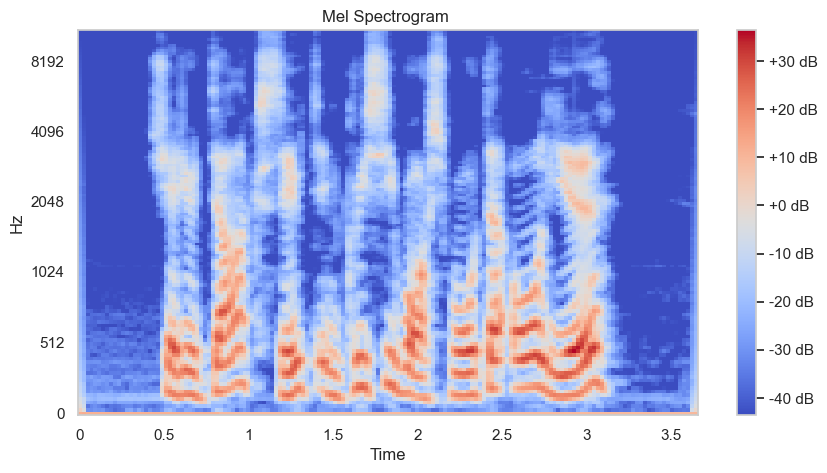

In [78]:
# CREATE LOG MEL SPECTROGRAM
plt.figure(figsize=(10, 5))
spectrogram = librosa.feature.melspectrogram(y=data, sr=sr, n_mels=128,fmax=8000) 
log_spectrogram = librosa.power_to_db(spectrogram)
librosa.display.specshow(log_spectrogram, y_axis='mel', sr=sr, x_axis='time');
plt.title('Mel Spectrogram ')
plt.colorbar(format='%+2.0f dB')

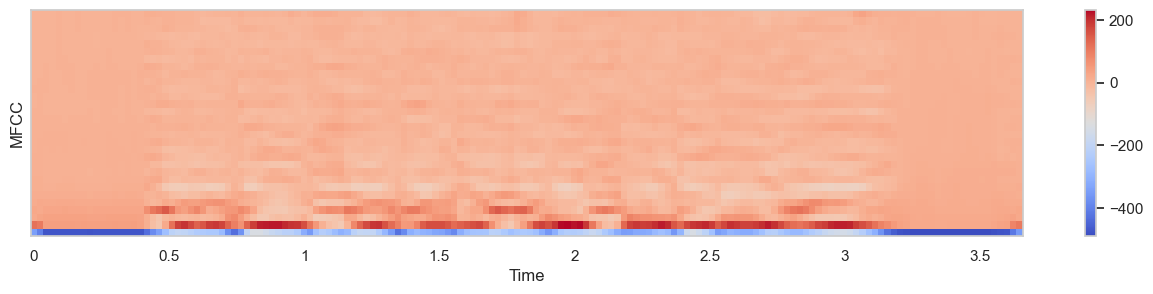

In [79]:
mfcc = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=30)


# MFCC
plt.figure(figsize=(16, 10))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

ipd.Audio(data,rate=sr)

# Data augmentation

In [80]:
# NOISE
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

# STRETCH
def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)
# SHIFT
def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)
# PITCH
def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(y=data, sr=sampling_rate, n_steps=pitch_factor)


# Feature extraction

In [81]:
def zcr(data,frame_length,hop_length):
    zcr=librosa.feature.zero_crossing_rate(data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(zcr)
def rmse(data, frame_length=2048, hop_length=512):
    rmse_values = librosa.feature.rms(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(rmse_values)
def mfcc(data, sr, frame_length=2048, hop_length=512, flatten: bool = True):
    mfcc_values = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=13)
    return np.squeeze(mfcc_values.T) if not flatten else np.ravel(mfcc_values.T)

def extract_features(data,sr=22050,frame_length=2048,hop_length=512):
    result=np.array([])
    
    result=np.hstack((result,
                      zcr(data,frame_length,hop_length),
                      rmse(data,frame_length,hop_length),
                      mfcc(data,sr,frame_length,hop_length)
                     ))
    return result

def get_features(path,duration=2.5, offset=0.6):
    data,sr=librosa.load(path,duration=duration,offset=offset)
    aud=extract_features(data)
    audio=np.array(aud)
    
    noised_audio=noise(data)
    aud2=extract_features(noised_audio)
    audio=np.vstack((audio,aud2))
    
    pitched_audio=pitch(data,sr)
    aud3=extract_features(pitched_audio)
    audio=np.vstack((audio,aud3))
    
    pitched_audio1=pitch(data,sr)
    pitched_noised_audio=noise(pitched_audio1)
    aud4=extract_features(pitched_noised_audio)
    audio=np.vstack((audio,aud4))
    
    return audio


In [82]:
import multiprocessing as mp
print("Number of processors: ", mp.cpu_count())

Number of processors:  8


In [83]:
import timeit
from tqdm import tqdm
start = timeit.default_timer()
X,Y=[],[]
for path,emotion,index in tqdm (zip(data_path.Path,data_path.Emotions,range(data_path.Path.shape[0]))):
    features=get_features(path)
    if index%500==0:
        print(f'{index} audio has been processed')
    for i in features:
        X.append(i)
        Y.append(emotion)
print('Done')
stop = timeit.default_timer()

print('Time: ', stop - start)         

1it [00:00,  9.62it/s]

0 audio has been processed


503it [00:43, 11.46it/s]

500 audio has been processed


1002it [01:27, 11.60it/s]

1000 audio has been processed


1502it [02:09, 12.74it/s]

1500 audio has been processed


2002it [02:52, 11.16it/s]

2000 audio has been processed


2502it [03:34, 13.16it/s]

2500 audio has been processed


3003it [04:12, 12.23it/s]

3000 audio has been processed


3503it [05:02, 11.42it/s]

3500 audio has been processed


4002it [05:46, 10.10it/s]

4000 audio has been processed


4501it [06:30, 10.26it/s]

4500 audio has been processed


5002it [07:13, 11.17it/s]

5000 audio has been processed


5502it [07:54, 12.29it/s]

5500 audio has been processed


6002it [08:33, 11.48it/s]

6000 audio has been processed


6502it [09:14, 12.73it/s]

6500 audio has been processed


7003it [09:55, 13.46it/s]

7000 audio has been processed


7502it [10:36, 12.75it/s]

7500 audio has been processed


8002it [11:18, 12.88it/s]

8000 audio has been processed


8502it [12:00, 12.72it/s]

8500 audio has been processed


9004it [12:39, 17.10it/s]

9000 audio has been processed


9502it [13:13, 15.44it/s]

9500 audio has been processed


10002it [13:48, 13.75it/s]

10000 audio has been processed


10502it [14:26, 11.75it/s]

10500 audio has been processed


11003it [15:02, 14.76it/s]

11000 audio has been processed


11503it [15:37, 12.95it/s]

11500 audio has been processed


11682it [15:51, 12.28it/s]


PermissionError: [Errno 13] Permission denied: 'ALL//.ipynb_checkpoints'

*  The .extend() method increases the length of the list by the number of elements that are provided to the method, so if you want to add multiple elements to the list, you can use this method.

In [84]:
len(X), len(Y), data_path.Path.shape


(46728, 46728, (12163,))

# Saving features

In [85]:
Emotions = pd.DataFrame(X)
Emotions['Emotions'] = Y
Emotions.to_csv('emotion.csv', index=False)
Emotions.head()

,0,1,2,3,4,5,6,7,8,9,...,1611,1612,1613,1614,1615,1616,1617,1618,1619,Emotions
0,0.173828,0.264648,0.372559,0.486328,0.625488,0.681152,0.720703,0.651855,0.562988,0.559082,...,0.816714,0.812341,0.807019,0.800742,0.793534,0.785372,0.776301,0.766315,0.755441,neutral
1,0.253418,0.380371,0.507812,0.506348,0.498047,0.486328,0.488770,0.492676,0.502441,0.506348,...,4.404244,-4.358115,-3.088275,-2.339996,-2.994431,0.007036,-0.647066,2.594292,4.501128,neutral
2,0.256348,0.354492,0.471191,0.414062,0.378418,0.373535,0.354492,0.408691,0.466797,0.522461,...,0.007222,0.007180,0.007128,0.007062,0.006994,0.006906,0.006816,0.006713,0.006601,neutral
3,0.238281,0.368164,0.477539,0.484375,0.486328,0.485352,0.492676,0.485840,0.497559,0.490723,...,2.147167,-3.381447,-1.162925,2.409336,-0.677871,-0.241697,-1.193601,-4.653376,-0.964341,neutral
4,0.247070,0.389648,0.564941,0.642578,0.665527,0.684570,0.676270,0.666992,0.648926,0.595703,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,neutral


In [86]:
Emotions = pd.read_csv('./emotion.csv')
Emotions.head()

,0,1,2,3,4,5,6,7,8,9,...,1611,1612,1613,1614,1615,1616,1617,1618,1619,Emotions
0,0.173828,0.264648,0.372559,0.486328,0.625488,0.681152,0.720703,0.651855,0.562988,0.559082,...,0.816714,0.812341,0.807019,0.800742,0.793534,0.785372,0.776301,0.766315,0.755441,neutral
1,0.253418,0.380371,0.507812,0.506348,0.498047,0.486328,0.488770,0.492676,0.502441,0.506348,...,4.404244,-4.358115,-3.088275,-2.339996,-2.994431,0.007036,-0.647066,2.594292,4.501128,neutral
2,0.256348,0.354492,0.471191,0.414062,0.378418,0.373535,0.354492,0.408691,0.466797,0.522461,...,0.007222,0.007180,0.007128,0.007062,0.006994,0.006906,0.006816,0.006713,0.006601,neutral
3,0.238281,0.368164,0.477539,0.484375,0.486328,0.485352,0.492676,0.485840,0.497559,0.490723,...,2.147167,-3.381447,-1.162925,2.409336,-0.677871,-0.241697,-1.193601,-4.653376,-0.964341,neutral
4,0.247070,0.389648,0.564941,0.642578,0.665527,0.684570,0.676270,0.666992,0.648926,0.595703,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,neutral


In [87]:
print(Emotions.isna().any())


0           False
1           False
2           False
3           False
4           False
            ...  
1616         True
1617         True
1618         True
1619         True
Emotions    False
Length: 1621, dtype: bool


In [88]:
Emotions=Emotions.fillna(0)
print(Emotions.isna().any())
Emotions.shape

0           False
1           False
2           False
3           False
4           False
            ...  
1616        False
1617        False
1618        False
1619        False
Emotions    False
Length: 1621, dtype: bool


(46728, 1621)

In [89]:
np.sum(Emotions.isna())

0           0
1           0
2           0
3           0
4           0
           ..
1616        0
1617        0
1618        0
1619        0
Emotions    0
Length: 1621, dtype: int64

# Data preparation

In [90]:
#taking all rows and all cols without last col for X which include features
#taking last col for Y, which include the emotions


X = Emotions.iloc[: ,:-1].values
Y = Emotions['Emotions'].values

In [91]:
# As this is a multiclass classification problem onehotencoding our Y
from sklearn.preprocessing import StandardScaler, OneHotEncoder
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()


In [92]:
print(Y.shape)
X.shape

(46728, 7)


(46728, 1620)

In [93]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=42,test_size=0.2, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((37382, 1620), (37382, 7), (9346, 1620), (9346, 7))

In [94]:
#reshape for lstm
X_train = x_train.reshape(x_train.shape[0] , x_train.shape[1] , 1)
X_test = x_test.reshape(x_test.shape[0] , x_test.shape[1] , 1)

In [95]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((37382, 1620), (37382, 7), (9346, 1620), (9346, 7))

In [96]:
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM,BatchNormalization , GRU
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD

> Applying early stopping for all models


In [97]:
from keras.callbacks import ModelCheckpoint, EarlyStopping,ReduceLROnPlateau
model_checkpoint = ModelCheckpoint('best_model1_weights.h5', monitor='val_accuracy', save_best_only=True)

In [98]:

early_stop=EarlyStopping(monitor='val_acc',mode='auto',patience=5,restore_best_weights=True)
lr_reduction=ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.5,min_lr=0.00001)

# CNN model

In [99]:
#Reshape for CNN_LSTM MODEL

x_traincnn =np.expand_dims(x_train, axis=2)
x_testcnn= np.expand_dims(x_test, axis=2)
x_traincnn.shape, y_train.shape, x_testcnn.shape, y_test.shape
#x_testcnn[0]

((37382, 1620, 1), (37382, 7), (9346, 1620, 1), (9346, 7))

In [100]:
import tensorflow.keras.layers as L

model = tf.keras.Sequential([
    L.Conv1D(512,kernel_size=5, strides=1,padding='same', activation='relu',input_shape=(X_train.shape[1],1)),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    
    L.Conv1D(512,kernel_size=5,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    Dropout(0.2),  # Add dropout layer after the second max pooling layer
    
    L.Conv1D(256,kernel_size=5,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    
    L.Conv1D(256,kernel_size=3,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    Dropout(0.2),  # Add dropout layer after the fourth max pooling layer
    
    L.Conv1D(128,kernel_size=3,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=3,strides=2,padding='same'),
    Dropout(0.2),  # Add dropout layer after the fifth max pooling layer
    
    L.Flatten(),
    L.Dense(512,activation='relu'),
    L.BatchNormalization(),
    L.Dense(7,activation='softmax')
])
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics='accuracy')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1620, 512)         3072      
_________________________________________________________________
batch_normalization (BatchNo (None, 1620, 512)         2048      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 810, 512)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 810, 512)          1311232   
_________________________________________________________________
batch_normalization_1 (Batch (None, 810, 512)          2048      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 405, 512)          0         
_________________________________________________________________
dropout (Dropout)            (None, 405, 512)          0

In [101]:
history=model.fit(x_traincnn, y_train, epochs=50, validation_data=(x_testcnn, y_test), batch_size=64,callbacks=[early_stop,lr_reduction,model_checkpoint])

Epoch 1/50
585/585 [==============================] - 260s 414ms/step - loss: 1.4284 - accuracy: 0.4538 - val_loss: 1.4991 - val_accuracy: 0.4264
Epoch 2/50
585/585 [==============================] - 242s 413ms/step - loss: 1.1840 - accuracy: 0.5396 - val_loss: 1.2114 - val_accuracy: 0.5391
Epoch 3/50
585/585 [==============================] - 242s 414ms/step - loss: 1.0834 - accuracy: 0.5817 - val_loss: 1.2274 - val_accuracy: 0.5387
Epoch 4/50
585/585 [==============================] - 241s 413ms/step - loss: 0.9990 - accuracy: 0.6178 - val_loss: 1.3362 - val_accuracy: 0.4800
Epoch 5/50
585/585 [==============================] - 241s 412ms/step - loss: 0.9272 - accuracy: 0.6420 - val_loss: 1.0333 - val_accuracy: 0.6026
Epoch 6/50
585/585 [==============================] - 241s 412ms/step - loss: 0.8321 - accuracy: 0.6853 - val_loss: 0.9362 - val_accuracy: 0.6550
Epoch 7/50
585/585 [==============================] - 241s 412ms/step - loss: 0.7422 - accuracy: 0.7198 - val_loss: 0.9047 -

293/293 [==============================] - 18s 57ms/step - loss: 0.1359 - accuracy: 0.9633
Accuracy of our model on test data :  96.3299810886383 %


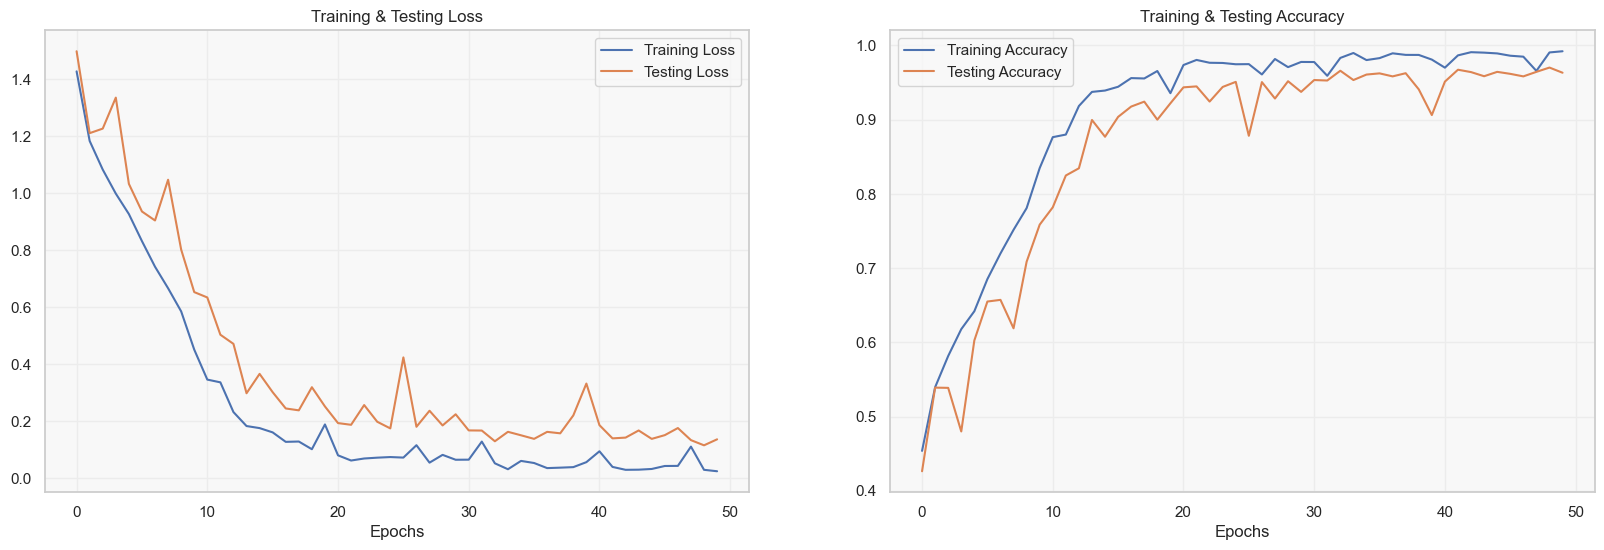

In [102]:
print("Accuracy of our model on test data : " , model.evaluate(x_testcnn,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [103]:
# predicting on test data.
pred_test0 = model.predict(x_testcnn)
y_pred0 = encoder.inverse_transform(pred_test0)
y_test0 = encoder.inverse_transform(y_test)

# Check for random predictions
df0 = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df0['Predicted Labels'] = y_pred0.flatten()
df0['Actual Labels'] = y_test0.flatten()

df0.head(10)

,Predicted Labels,Actual Labels
0,disgust,disgust
1,neutral,neutral
2,happy,happy
3,neutral,neutral
4,angry,angry
5,fear,fear
6,sad,sad
7,disgust,disgust
8,disgust,disgust
9,fear,fear


In [104]:
df0

,Predicted Labels,Actual Labels
0,disgust,disgust
1,neutral,neutral
2,happy,happy
3,neutral,neutral
4,angry,angry
...,...,...
9341,fear,fear
9342,happy,happy
9343,sad,sad
9344,angry,angry


Some plots of multi_model
______________________________________________


Model that have lstm layers take alot of time if you have much free time enjoy with it

Another  model (CLSTM)  omnia model
_____________________________________________________

In [ ]:
#Build the model

# define model
"""model000 = Sequential()
model000.add(Conv1D(1024, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(X.shape[1], 1)))
model000.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
model000.add(BatchNormalization())
model000.add(Dropout(0.3))

          
model000.add(Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu'))
model000.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
model000.add(BatchNormalization())
model000.add(Dropout(0.3))

model000.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model000.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
model000.add(BatchNormalization())
model000.add(Dropout(0.3))
          
model000.add(LSTM(128, return_sequences=True)) 
model000.add(Dropout(0.3))

model000.add(LSTM(128, return_sequences=True)) 
model000.add(Dropout(0.3))
model000.add(LSTM(128))
model000.add(Dropout(0.3))

model000.add(Dense(128, activation='relu'))
#model000.add(Dropout(0.3))

model000.add(Dense(64, activation='relu'))
#model000.add(Dropout(0.3))

model000.add(Dense(32, activation='relu'))
#model000.add(Dropout(0.3))

model000.add(Dense(7, activation='softmax'))



model000.summary()"""

In [ ]:
"""from keras.utils.vis_utils import plot_model
plot_model( model000, show_shapes=True, show_layer_names=True, to_file='model000.png')"""

In [ ]:
"""model000.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])"""

In [ ]:
"""hist1=model000.fit(x_traincnn, y_train, batch_size=64, epochs=40, validation_data=(x_testcnn, y_test))"""

In [ ]:
"""print("Accuracy of our model on test data : " , model000.evaluate(x_testcnn,y_test)[1]*100 , "%")
epochs = [i for i in range(40)]
fig , ax = plt.subplots(1,2)
train_acc = hist1.history['accuracy']
train_loss = hist1.history['loss']
test_acc = hist1.history['val_accuracy']
test_loss = hist1.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()"""

In [ ]:
# predicting on test data.
"""pred_test00 = model000.predict(x_testcnn)
y_pred00 = encoder.inverse_transform(pred_test)
y_test00 = encoder.inverse_transform(y_test)

# Check for random predictions
df0 = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df0['Predicted Labels'] = y_pred00.flatten()
df0['Actual Labels'] = y_test00.flatten()

df0.head(10)"""

# Evalutation

Results of best model

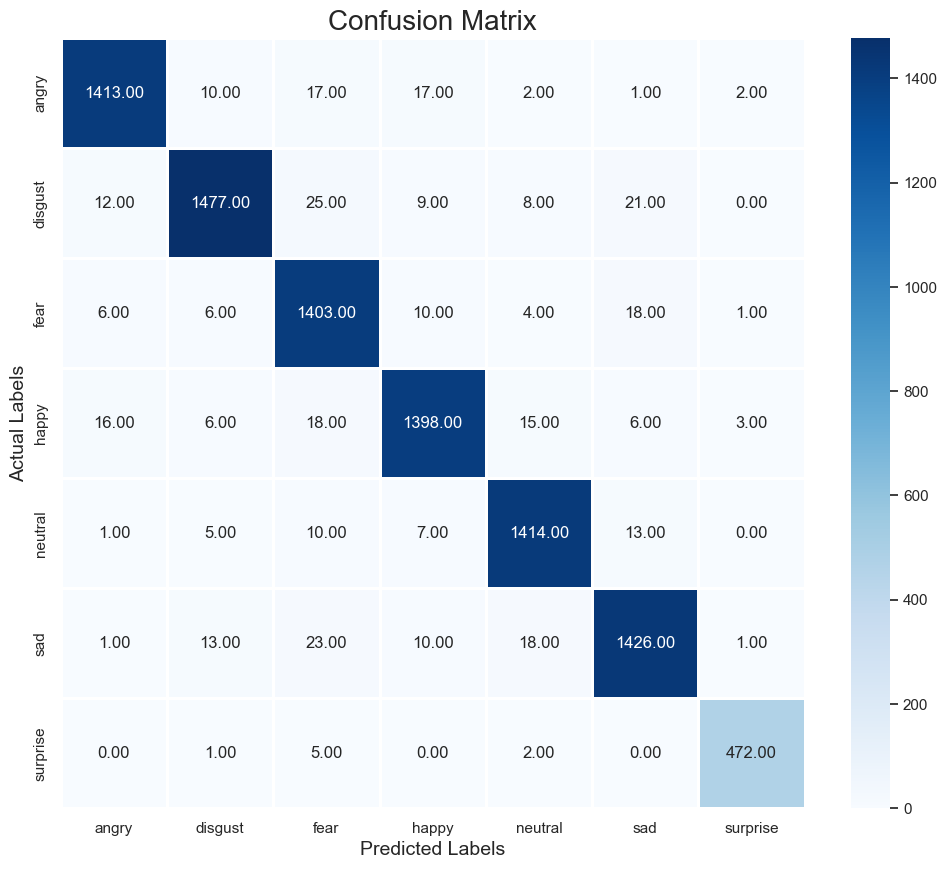

              precision    recall  f1-score   support

       angry       0.98      0.97      0.97      1462
     disgust       0.97      0.95      0.96      1552
        fear       0.93      0.97      0.95      1448
       happy       0.96      0.96      0.96      1462
     neutral       0.97      0.98      0.97      1450
         sad       0.96      0.96      0.96      1492
    surprise       0.99      0.98      0.98       480

    accuracy                           0.96      9346
   macro avg       0.97      0.97      0.97      9346
weighted avg       0.96      0.96      0.96      9346



In [105]:
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(y_test0, y_pred0)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
#cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='.2f')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()
print(classification_report(y_test0, y_pred0))

# Saving Best Model

In [106]:
# MLP for Pima Indians Dataset Serialize to JSON and HDF5
from tensorflow.keras.models import Sequential, model_from_json
model_json = model.to_json()
with open("CNN_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("CNN_model_weights.h5")
print("Saved model to disk") 

Saved model to disk


In [108]:
tf.keras.models.save_model(model, "CNN.Model")

INFO:tensorflow:Assets written to: CNN.Model\assets


In [110]:
from tensorflow.keras.models import Sequential, model_from_json
json_file = open('CNN_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("best_model1_weights.h5")
print("Loaded model from disk")

Loaded model from disk


In [ ]:
loaded_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn,y_test)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))


293/293 [==============================] - 17s 57ms/step - loss: 0.1148 - accuracy: 0.9703
accuracy: 97.03%


# Saving and Loading our Stnadrad Scaler and encoder
* To save the StandardScaler object to use it later in a Flask API

pickle file


In [112]:
import pickle

# Saving scaler
with open('scaler2.pickle', 'wb') as f:
    pickle.dump(scaler, f)

# Loading scaler
with open('scaler2.pickle', 'rb') as f:
    scaler2 = pickle.load(f)

# Saving encoder
with open('encoder2.pickle', 'wb') as f:
    pickle.dump(encoder, f)

# Loading encoder
with open('encoder2.pickle', 'rb') as f:
    encoder2 = pickle.load(f)

    
print("Done")    

Done


# Test script
* That can predict new record 

In [114]:
from tensorflow.keras.models import Sequential, model_from_json
json_file = open('CNN_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("best_model1_weights.h5")
print("Loaded model from disk")

Loaded model from disk


In [116]:
import pickle

with open('scaler2.pickle', 'rb') as f:
    scaler2 = pickle.load(f)
    
with open('encoder2.pickle', 'rb') as f:
    encoder2 = pickle.load(f)

    
print("Done")    

Done


In [132]:
import librosa

In [141]:
def zcr(data,frame_length,hop_length):
    zcr=librosa.feature.zero_crossing_rate(data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(zcr)
def rmse(data, frame_length=2048, hop_length=512):
    rmse_values = librosa.feature.rms(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(rmse_values)
def mfcc(data, sr, frame_length=2048, hop_length=512, flatten: bool=True):
    mfcc_values = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=20, hop_length=hop_length)
    return np.ravel(mfcc_values.T) if flatten else np.squeeze(mfcc_values.T)


def extract_features(data,sr=22050,frame_length=2048,hop_length=512):
    result=np.array([])
    
    result=np.hstack((result,
                      zcr(data,frame_length,hop_length),
                      rmse(data,frame_length,hop_length),
                      mfcc(data,sr,frame_length,hop_length)
                     ))
    return result

In [145]:
def get_predict_feat(path):
    d, s_rate= librosa.load(path, duration=2.5, offset=0.6)
    res=extract_features(d)
    result=np.array(res)
    result=np.reshape(result,newshape=(1,1620))
    i_result = scaler2.transform(result)
    final_result=np.expand_dims(i_result, axis=2)
    
    return final_result

In [146]:
res=get_predict_feat("RAVDESS Emotional speech audio/Actor_01/03-01-01-01-01-01-01.wav")
print(res.shape)

ValueError: cannot reshape array of size 2376 into shape (1,1620)

In [123]:
emotions1={1:'Neutral', 2:'Calm', 3:'Happy', 4:'Sad', 5:'Angry', 6:'Fear', 7:'Disgust',8:'Surprise'}
def prediction(path1):
    res=get_predict_feat(path1)
    predictions=loaded_model.predict(res)
    y_pred = encoder2.inverse_transform(predictions)
    print(y_pred[0][0])    

In [124]:
prediction("/kaggle/input/ravdess-emotional-speech-audio/Actor_02/03-01-01-01-01-01-02.wav")

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/ravdess-emotional-speech-audio/Actor_02/03-01-01-01-01-01-02.wav'

In [1]:
prediction("/kaggle/input/ravdess-emotional-speech-audio/Actor_01/03-01-01-01-01-01-01.wav")

NameError: name 'prediction' is not defined

In [ ]:
prediction("/kaggle/input/ravdess-emotional-speech-audio/Actor_01/03-01-05-01-02-02-01.wav")

In [ ]:
prediction("/kaggle/input/ravdess-emotional-speech-audio/Actor_21/03-01-04-02-02-02-21.wav")

In [ ]:
prediction("/kaggle/input/ravdess-emotional-speech-audio/Actor_02/03-01-06-01-02-02-02.wav")

In [ ]:
prediction("/kaggle/input/ravdess-emotional-speech-audio/Actor_01/03-01-08-01-01-01-01.wav")

In [ ]:
prediction("/kaggle/input/ravdess-emotional-speech-audio/Actor_01/03-01-07-01-01-01-01.wav")